# Real or Not? NLP with Disaster Tweets
### Objective : Predict which Tweets are about real disasters and which ones are not.

##### Libraries/Packages :

In [1]:
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

# Printing the progress :
from tqdm import tqdm

# Data visualization :
import matplotlib.pyplot as plt
plt.style.use('ggplot')    
import seaborn as sns

# NLP (Natural Language Processing) :
from collections import defaultdict
import wordcloud
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Tensorflow/keras :
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import  Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional,SpatialDropout1D, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,make_scorer

# Word Cloud :
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im

In [2]:
# https://www.kaggle.com/tuckerarrants/disaster-tweets-eda-glove-rnns-bert

##### Seeding :

In [3]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(50)

##### Reading the csv files :

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
len(test)

3263

In [6]:
train['target'][:5]

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [7]:
test[:5]

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### Word Cloud :

In [8]:
unique_keywords = train['keyword'].unique().tolist()[1:]
unique_keywords[:10]

['ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army']

In [9]:
# Remove keywords containing digits :
unique_keywords = [x for x in unique_keywords if not any(c.isdigit() for c in x)]

In [10]:
unique_keywords[:10]

['ablaze',
 'accident',
 'aftershock',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson']

In [11]:
wc = WordCloud(width = 200, height = 200, random_state=1,background_color="black", max_words=50)
clean_string = ' '.join(unique_keywords)
wc.generate(clean_string)

In [12]:
# Define a function to plot word cloud
def plot_cloud(wordcloudInput):
    # Set figure size
    plt.figure(figsize=(40, 30))
    
    # Display image
    plt.imshow(wordcloudInput)
    
    # No axis details
    plt.axis("off");

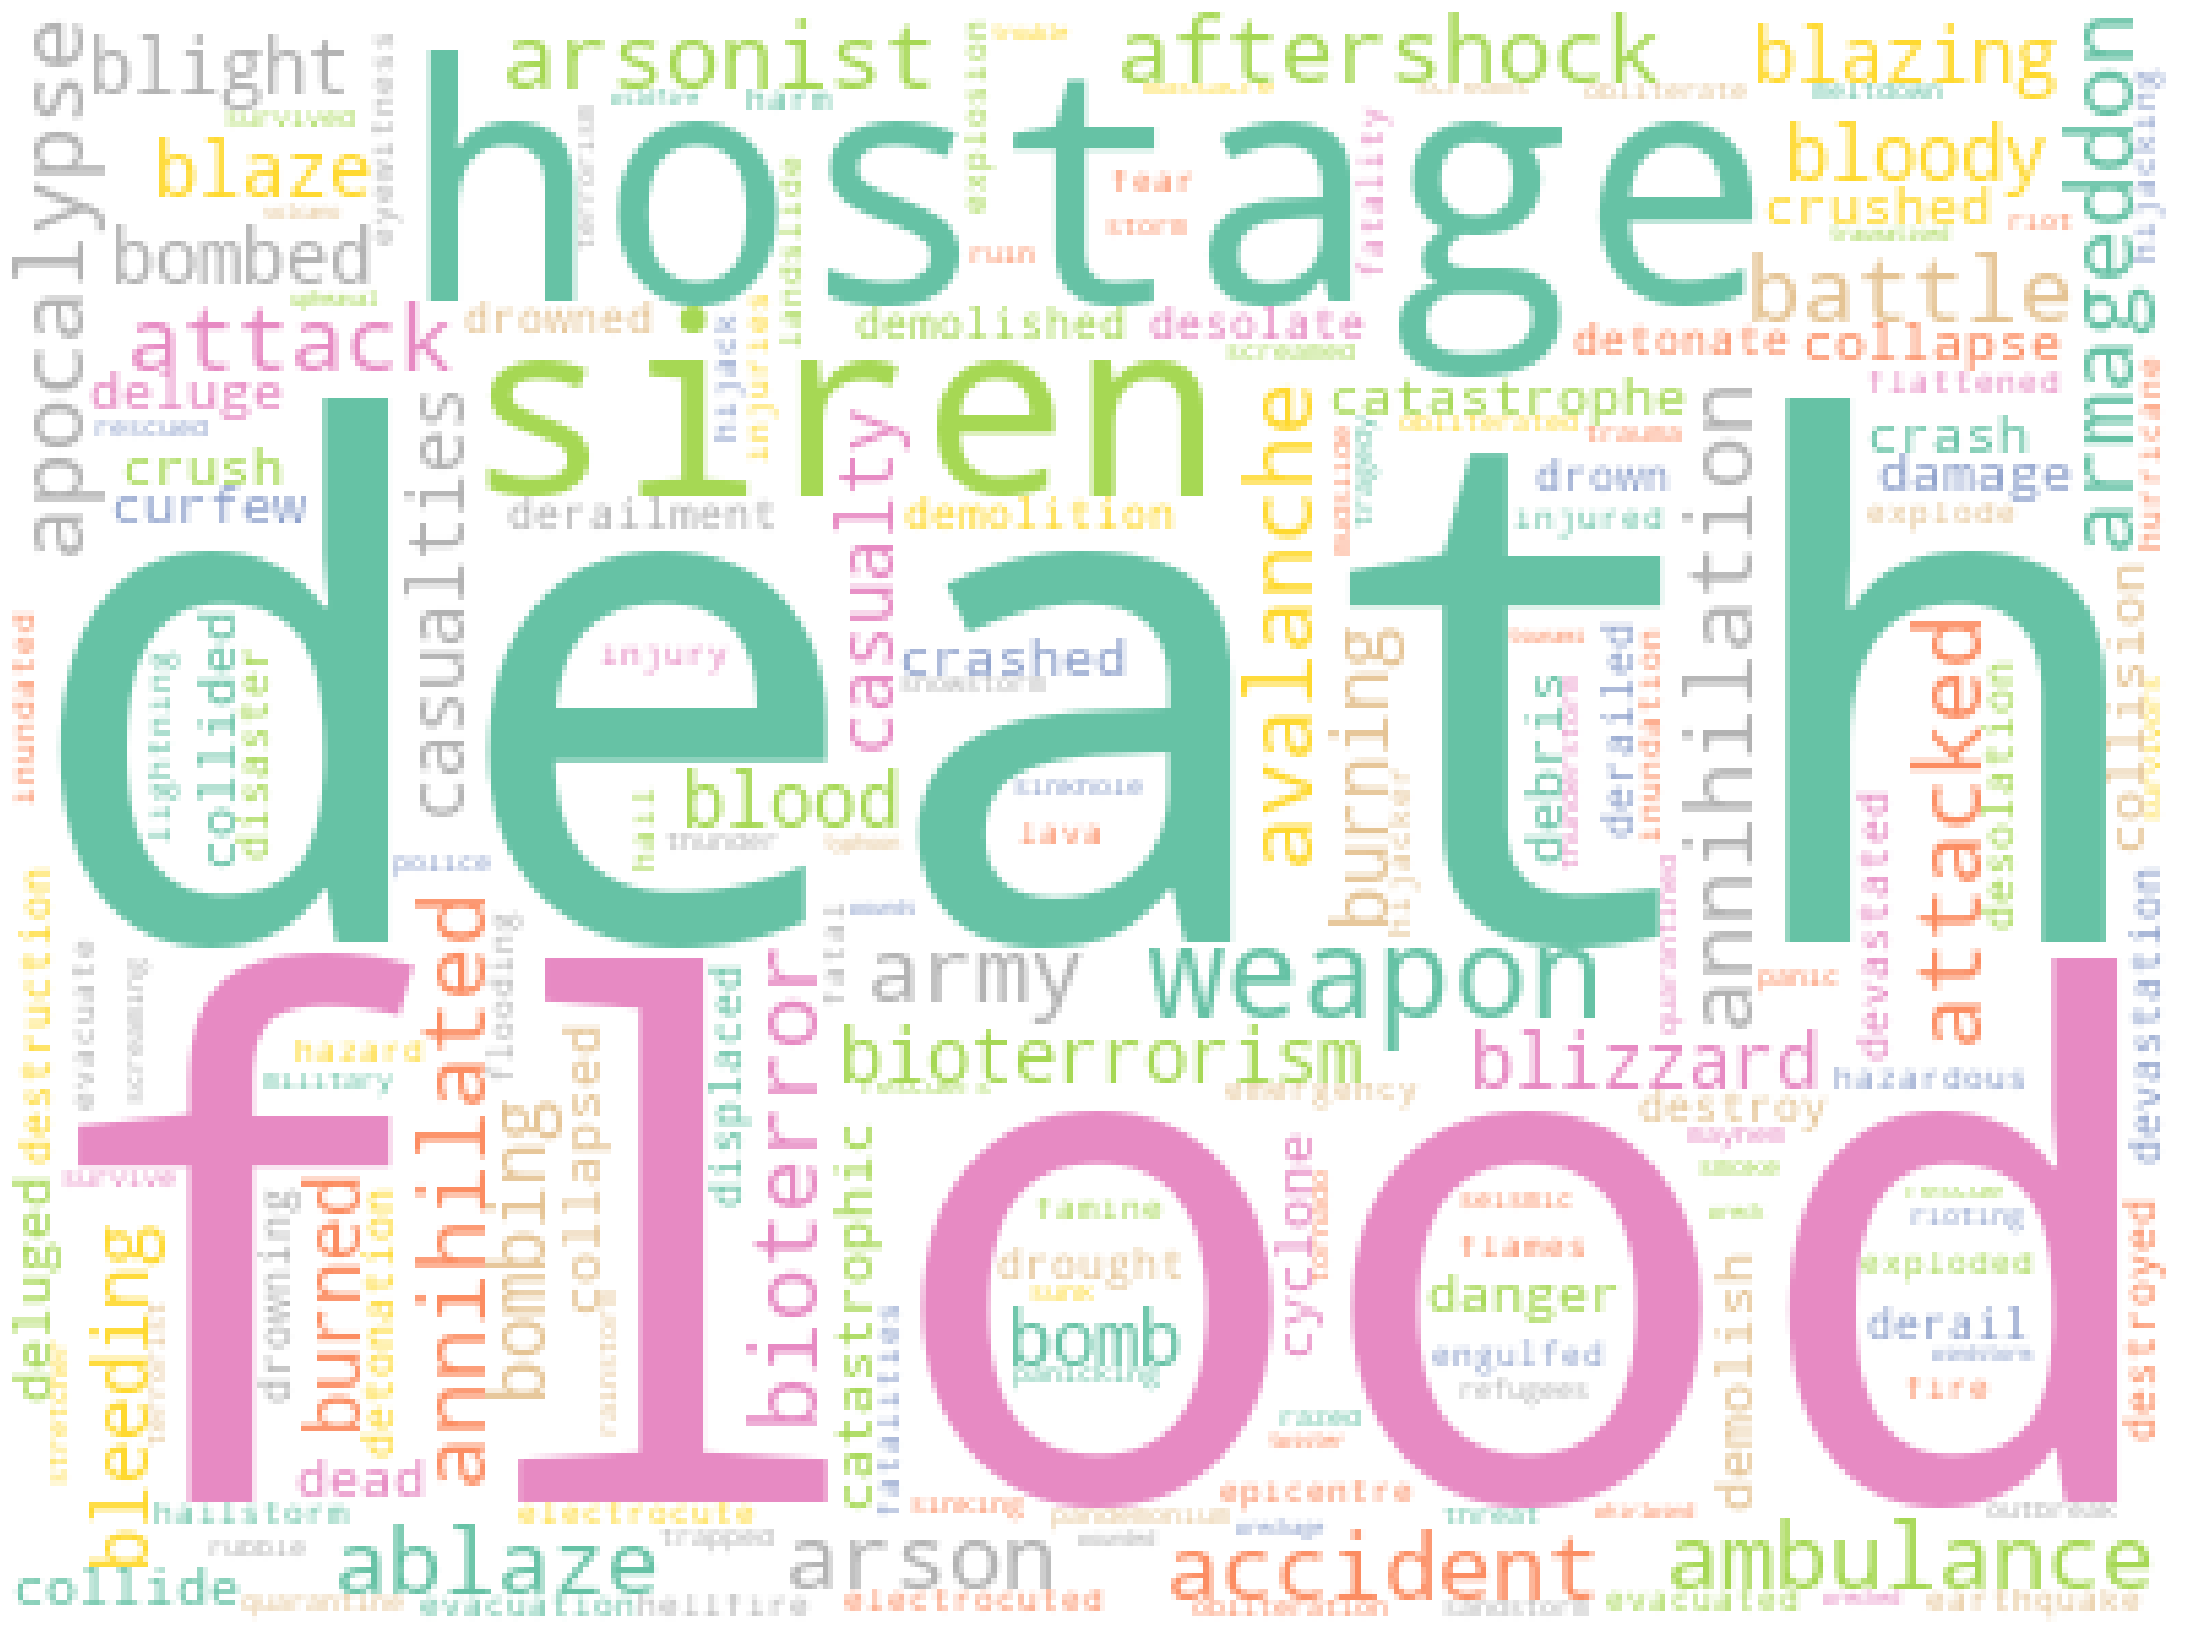

In [13]:
# Generate wordcloud

clean_string = ' '.join(unique_keywords)
generate_wordcloud = WordCloud(width = 400, height = 300, random_state=1, background_color='white', 
                      colormap='Set2', collocations=True, stopwords = STOPWORDS).generate(clean_string)
# Plot
plot_cloud(generate_wordcloud)

In [14]:
generate_wordcloud.to_file('word_cloud.png')

##### Dropping columns "ID" & "Location" as they don't have much of a significance :

In [15]:
test_id = test['id']

columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

##### The column "Keyword" has a lot of missing values => Replacing the missing keywords with a space : :

In [16]:
train['keyword'] = train['keyword'].fillna(' ')
test['keyword'] = test['keyword'].fillna(' ')

##### Adding the "keywords" to the tweets so that the "keyword" column can be dropped as well :

In [17]:
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

##### Dropping column "keyword"  :

In [18]:
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

##### Length of Training/Testing datasets :

In [19]:
print('The Training Dataset has ', len(train), 'rows in the train set')
print('The Testing Dataset has ', len(test), 'rows in the test set')

The Training Dataset has  7613 rows in the train set
The Testing Dataset has  3263 rows in the test set


In [20]:
x = train.groupby(['target']).sum()
train[:5]

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


##### Distribution of Target classes :

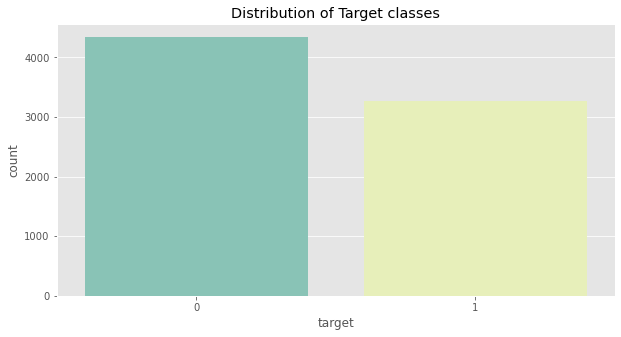

In [21]:

fig, ax = plt.subplots(figsize = (10, 5))
plot1 = sns.countplot(x = 'target', data = train, palette=['#7fcdbb','#edf8b1'])
plt.title('Distribution of Target classes')
plt.show(plot1)

##### Counting the number of words in each tweet :

In [22]:
train['word count'] = train['text'].apply(lambda x: len(x.split()))
test['word count'] = test['text'].apply(lambda x: len(x.split()))

In [23]:
# Displaying the words in the Training tweets :
train['word count'][:5]

0    13
1     7
2    22
3     8
4    16
Name: word count, dtype: int64

In [24]:
# Displaying the words in the Testing tweets :
test['word count'][:5]

0     6
1     9
2    19
3     4
4     8
Name: word count, dtype: int64

##### Word Count distribution in the Training dataset :

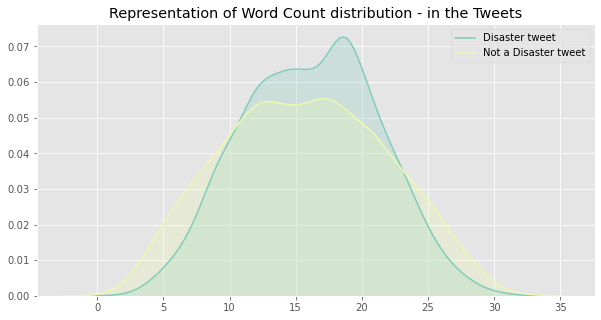

In [25]:

fig, ax = plt.subplots(figsize = (10, 5))
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet', color='#7fcdbb')
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not a Disaster tweet', color='#edf8b1')

plt.title('Representation of Word Count distribution - in the Tweets')
plt.show()

##### Distribution of Tweet Character Count :

In [26]:
# Distribution of number of characters in a tweet :
train['character count'] = train['text'].apply(lambda x: len(x))
test['character count'] = test['text'].apply(lambda x: len(x))


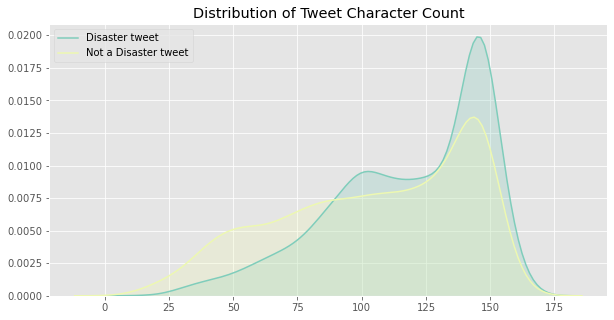

In [27]:

fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target'] == 1], shade = True, label = 'Disaster tweet', color ="#7fcdbb")
sns.kdeplot(train['character count'][train['target'] == 0], shade = True, label = 'Not a Disaster tweet', color ="#edf8b1")

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()

##### Distribution of Tweet Average Word Length

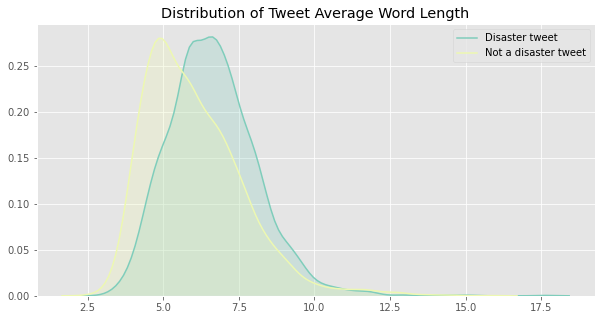

In [28]:
# Function to calculate the average word length of Tweets :
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

train['average word length'] = train['text'].apply(average_word_length)
test['average word length'] = test['text'].apply(average_word_length)

# Plot :
fig, ax = plt.subplots(figsize = (10, 5))
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Disaster tweet', color ="#7fcdbb")
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Not a disaster tweet', color ="#edf8b1")

plt.title('Distribution of Tweet Average Word Length')
plt.show()

### Text Processing :

##### 1. Elimination of Punctuation marks :

In [29]:
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

##### 2. Elimination of Stop words :

In [30]:
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])    

##### 3. Elimination of words that are Non Alphabet :

In [31]:
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

##### 4. Strip words :

In [32]:
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

##### 5. Removal of hashtag symbol(#) from the hashtagged words for better training :

In [33]:
def remove_hashtag(x):
    return " ".join(word.strip() for word in re.split('#|_', x))

##### 6. Spell check :

In [34]:
from autocorrect import Speller 
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

# Validating the spell_check function :
mispelled = 'Pleaze infirm the Profisser about all the chinges'
spell_check(mispelled)

'Please inform the Professor about all the changes'

##### Applying the Text Pre-Processing to the Training dataset :

In [35]:
# TRAIN DATA
train['text'] = train['text'].apply(lambda x: x.lower())
train['text'] = train['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
train['text'] = train['text'].apply(lambda x: re.sub(r'http?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
train['text'] = train['text'].apply(remove_punctuation)
train['text'] = train['text'].apply(remove_stopwords)
#train['text'] = train['text'].apply(remove_less_than)
train['text'] = train['text'].apply(remove_non_alphabet)
#train['text'] = train['text'].apply(spell_check)

##### Applying the Text Pre-Processing to the Testing dataset :

In [36]:
# TEST DATA
test['text'] = test['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
test['text'] = test['text'].apply(lambda x: re.sub(r'http?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
test['text'] = test['text'].apply(remove_punctuation)
test['text'] = test['text'].apply(remove_stopwords)
#test['text'] = test['text'].apply(remove_less_than)
test['text'] = test['text'].apply(remove_non_alphabet)
#test['text'] = test['text'].apply(spell_check)

#### Elaborating all the shortforms/abbreviations/word-contractions :

##### The below list of word contractions have been taken from :
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

* This is necessary as we may lose the actual meaning of certain contractions, if not expanded correctly.

In [37]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


In [38]:
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

##### Validating the expand_contractions function :

In [39]:
expand_contractions("couldn't find anything better than what you've figured out, they'll have to accept yours")

'could not find anything better than what you have figured out, they shall / they will have to accept yours'

In [40]:
#a Applying the above function to Training/Testing data :
train['text'] = train['text'].apply(expand_contractions)
test['text'] = test['text'].apply(expand_contractions)

##### Expanding Abbreviations/acronyms/hashtag/slang/typo corrections
* Below are some of the expanded hasgtags/acronyms :

In [41]:
def clean(tweet):

    # acronyms :
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    # typos :
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames :
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet


##### Applying the above function to our datasets :

In [42]:
train['text'] = train['text'].apply(clean)
test['text'] = test['text'].apply(clean)

##### Length of Datasets :

In [43]:
len(train)

7613

In [44]:
len(test)

3263

##### Displaying first 5 preprocessed Training records :

In [45]:
train.head()

,text,target,word count,character count,average word length
0,deeds reason earthquake may allah forgive us,1,13,71,4.384615
1,forest fire near la ronge sask canada,1,7,40,4.571429
2,residents asked shelter place notified officer...,1,22,135,5.090909
3,people receive wildfires evacuation orders cal...,1,8,67,7.125000
4,got sent photo ruby alaska smoke wildfires pou...,1,16,90,4.500000


##### Displaying first 5 preprocessed Testing records :

In [46]:
test.head()

,text,word count,character count,average word length
0,happened terrible car crash,6,36,4.833333
1,heard earthquake different cities stay safe ev...,9,66,6.222222
2,forest fire spot pond geese fleeing across str...,19,98,4.105263
3,apocalypse lighting spokane wildfires,4,42,9.250000
4,typhoon soudelor kills china taiwan,8,47,4.750000


##### Assigning the X and Y variables :

##### Splitting the dataset :

In [47]:
X = train['text']
y = train['target']

In [48]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=50)


##### Text Representation using TDIDF :

In [49]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),min_df=3,strip_accents='unicode', 
                           use_idf=1,smooth_idf=1, sublinear_tf=1,max_features=None)

vectorizer.fit(list(train['text'])+list(test['text']))

print('vocab length',len(vectorizer.vocabulary_))

vocab length 11429


In [50]:
len(vectorizer.idf_)

11429

In [51]:
vectorizer.idf_[:30]

array([8.90811139, 7.20336329, 7.29867347, 7.29867347, 8.90811139,
       7.4611924 , 8.21496421, 8.3484956 , 8.68496783, 8.68496783,
       8.90811139, 8.21496421, 8.21496421, 8.21496421, 6.71088681,
       7.07552992, 7.40403399, 8.21496421, 8.90811139, 8.90811139,
       8.68496783, 8.50264628, 6.36258011, 7.72945639, 7.72945639,
       8.50264628, 8.68496783, 8.90811139, 8.21496421, 7.15891153])

In [52]:
list(train['text'])[:10]

['deeds reason earthquake may allah forgive us',
 'forest fire near la ronge sask canada',
 'residents asked shelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school',
 'rockyfire update california hwy closed directions due lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
 'im top hill see fire woods',
 'theres emergency evacuation happening now building across street',
 'im afraid tornado coming area']

In [53]:
X_train_dnn = vectorizer.transform(X_train).todense()
X_val_dnn = vectorizer.transform(X_val).todense()

In [54]:
X_train_dnn[:1]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [55]:
np.shape(X_train_dnn)[0]

6090

In [56]:
np.shape(X_val_dnn)[0]

1523

#### MODEL 1 : Dense Neural Network (DNN) :

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=np.shape(X_train_dnn)[1],
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



#### Model compilation :

In [58]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=10**-8, decay=0.0001, amsgrad=False)
model.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5852160   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

##### Model Training :

In [59]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [60]:
history_DNN = model.fit(X_train_dnn, y_train,validation_data = (X_val_dnn, y_val),
                 epochs=25,verbose=0, callbacks = [PrintDot()])


.........................

##### Accuracy of the DNN Model :

In [61]:
print(max(history_DNN.history['accuracy']))
print(max(history_DNN.history['val_accuracy']))

0.9665024876594543
0.7780696153640747


In [62]:
X_val_dnn

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

#### DNN Model Predictions :

In [63]:
dnn_pred = (model.predict(X_val_dnn) > 0.5).astype("int32")
dnn_pred[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

In [64]:
len(dnn_pred)

1523

### DNN Predictions

In [137]:
for i,j in zip(test.text.values[2:30], dnn_pred[2:30]):
    print("Tweet: ", i)
    if j==0:
        print("The category is = ", j, "implying that it is not a Disaster tweet \n")
    else:
        print("The category is = ", j, "implying that it is a Disaster tweet \n")

Tweet:  forest fire spot pond geese fleeing across street save
The category is =  [1] implying that it is a Disaster tweet 

Tweet:  apocalypse lighting spokane wildfires
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  typhoon soudelor kills china taiwan
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  shakingits earthquake
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  theyd probably still show life arsenal yesterday eh eh
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  hey
The category is =  [1] implying that it is a Disaster tweet 

Tweet:  nice hat
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  fuck
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  dont cold
The category is =  [0] implying that it is not a Disaster tweet 

Tweet:  nooooooooo dont
The category is =  [1] implying that it is a Disaster tweet 

Tweet:  dont tell
The 

#### Confusion Matrix :

In [105]:
print('accuracy score: ',accuracy_score(dnn_pred,y_val))
print(classification_report(y_val, dnn_pred))

accuracy score:  0.7715036112934996
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       848
           1       0.80      0.65      0.72       675

    accuracy                           0.77      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [106]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true)[::-1])
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true)[::-1], columns=np.unique(y_true)[::-1])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

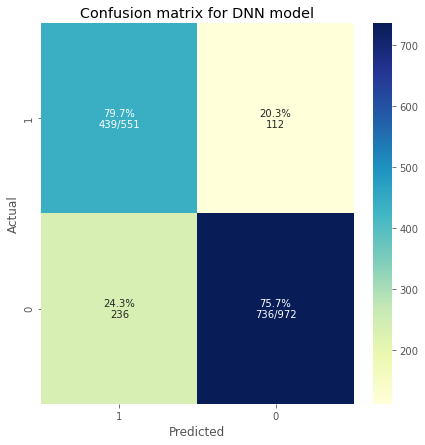

In [107]:
#Showing Confusion Matrix for DNN model
plot_cm(dnn_pred, y_val, 'Confusion matrix for DNN model', figsize=(7,7))

#### Plot :

In [69]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()


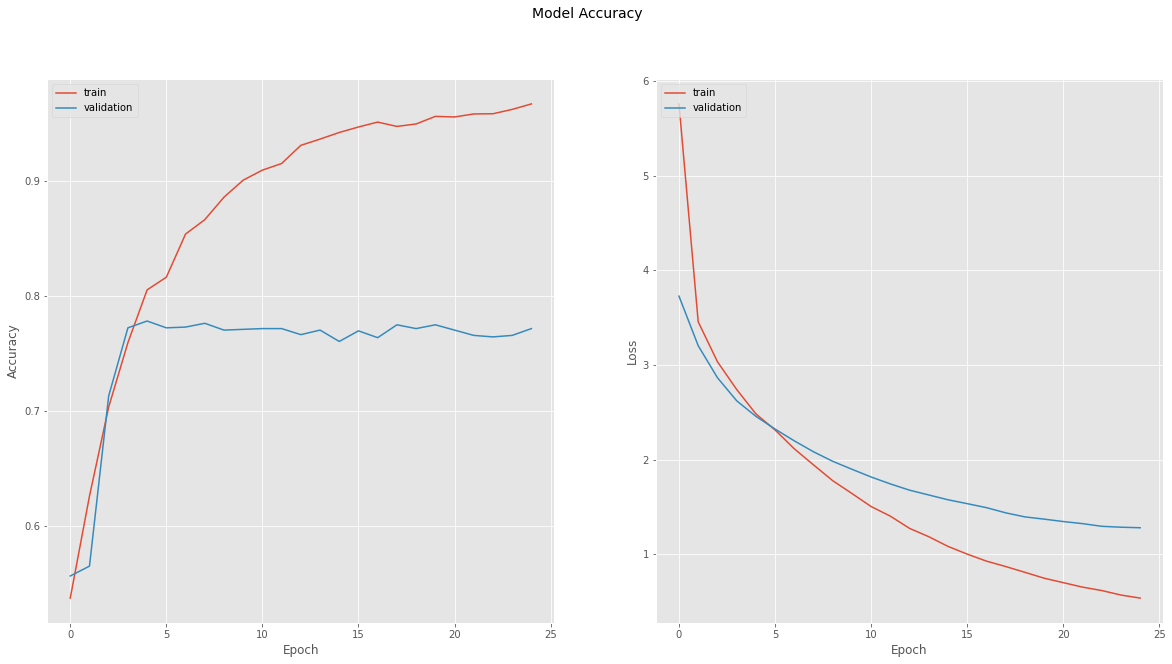

In [70]:
plot_learning_curves(history_DNN)

### Model 2 CNN

In [111]:
#Method to plot accuracy plots for CNN model
def plotMethod(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

In [112]:
#Method to predict and return the targets
def predict(testt,model):
    test=[x for x in testt]
    test=np.array(test)
    test_seq=tokenizer.texts_to_sequences(test)
    test_padded=pad_sequences(test_seq,maxlen=max_length,truncating=trun,padding='post')  
    pred=model.predict(test_padded).squeeze()
    pred=[1 if x>0.5 else 0 for x in pred]
    return pred

In [113]:
train.shape

(7613, 5)

In [114]:
test.shape

(3263, 4)

In [115]:
# assigning the train and test
train_X_cnn=train.text.values
train_y_cnn=train.target.values
test_X_cnn=test.text.values

In [116]:
# loading the train and test
train_X_cnn,val_X_cnn,train_y_cnn,val_y_cnn=train_test_split(train_X_cnn,train_y_cnn,shuffle=True)
print(train_X_cnn[:5])
print("--------------------------")
print(train_y_cnn[:5])

['liked youtube video homeless dog living cardboard box gets rescued amp heartwarming rescued'
 'remembered old song something havent heared years words carry floods memories along priceless floods'
 'Australian politics see resemblance abbott amp campbell loud came big bang way lets see'
 'sj gist houses farm produce destroy streetjamzdotnet destroy'
 'rjkrraj karnakarank vimvith whether pressure non wud survived even thalapathi didnt release survived']
--------------------------
[0 0 0 1 1]


In [117]:
#test and train shape
train_X_cnn=np.array(train_X_cnn)
train_X_cnn.shape

(5709,)

In [118]:
# Tokenizing and padding the tweets
trun='post'
max_length=150
tokenizer=Tokenizer(num_words=1000,oov_token='<OOV>')
tokenizer.fit_on_texts(train_X_cnn)
word_index=tokenizer.word_index
seq=tokenizer.texts_to_sequences(train_X_cnn)
padded=pad_sequences(seq,maxlen=max_length,truncating=trun,padding='post')

val_seq=tokenizer.texts_to_sequences(val_X_cnn)
val_padded=pad_sequences(val_seq,maxlen=max_length,truncating=trun,padding='post')

In [119]:
# define the cnn model
model_cnn=tf.keras.Sequential([
    tf.keras.layers.Embedding(1000,20,input_length=max_length),
    tf.keras.layers.Conv1D(64,5,activation='relu'),
    tf.keras.layers.Conv1D(64,5,activation='relu'),
    tf.keras.layers.Conv1D(64,5,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D() ,
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(264,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 20)           20000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 146, 64)           6464      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 142, 64)           20544     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 138, 64)           20544     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [120]:
# compile and fit the model
model_cnn.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
history_CNN=model_cnn.fit(padded,train_y_cnn,epochs=20,validation_data=(val_padded,val_y_cnn))

Epoch 1/20
179/179 [==============================] - 4s 25ms/step - loss: 0.6278 - accuracy: 0.6441 - val_loss: 0.5558 - val_accuracy: 0.7379
Epoch 2/20
179/179 [==============================] - 4s 25ms/step - loss: 0.4785 - accuracy: 0.7875 - val_loss: 0.5171 - val_accuracy: 0.7694
Epoch 3/20
179/179 [==============================] - 5s 26ms/step - loss: 0.4395 - accuracy: 0.8064 - val_loss: 0.4884 - val_accuracy: 0.7731
Epoch 4/20
179/179 [==============================] - 5s 26ms/step - loss: 0.4236 - accuracy: 0.8192 - val_loss: 0.5017 - val_accuracy: 0.7705
Epoch 5/20
179/179 [==============================] - 5s 25ms/step - loss: 0.4127 - accuracy: 0.8234 - val_loss: 0.4849 - val_accuracy: 0.7763
Epoch 6/20
179/179 [==============================] - 5s 25ms/step - loss: 0.4005 - accuracy: 0.8304 - val_loss: 0.4763 - val_accuracy: 0.7826
Epoch 7/20
179/179 [==============================] - 5s 25ms/step - loss: 0.3881 - accuracy: 0.8366 - val_loss: 0.4797 - val_accuracy: 0.7826

In [121]:
print(max(history_CNN.history['accuracy']))
print(max(history_CNN.history['val_accuracy']))

0.9416710734367371
0.7841386795043945


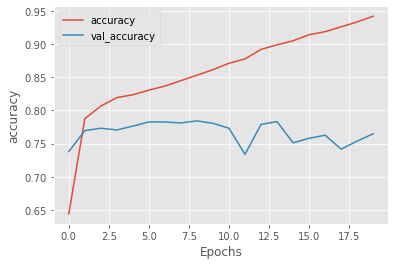

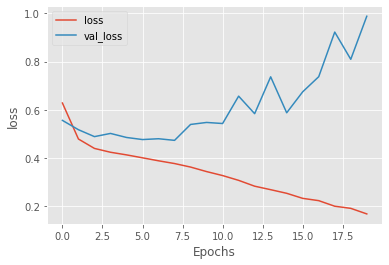

In [122]:
#plotting the accuracy and loss
plotMethod(history_CNN,'accuracy')
plotMethod(history_CNN,'loss')

### CNN Predictions

In [138]:
cnn_pred = predict(val_X_cnn,model_cnn)
#Predictions for CNN model
for i, j in zip(train_X_cnn[:50], cnn_pred[:50]):
    print("Tweet to predict :", i)
    print("The Category found is :", "Disaster tweet" if j==1 else "Not a Disaster tweet")

Tweet to predict : liked youtube video homeless dog living cardboard box gets rescued amp heartwarming rescued
The Category found is : Not a Disaster tweet
Tweet to predict : remembered old song something havent heared years words carry floods memories along priceless floods
The Category found is : Disaster tweet
Tweet to predict : Australian politics see resemblance abbott amp campbell loud came big bang way lets see
The Category found is : Not a Disaster tweet
Tweet to predict : sj gist houses farm produce destroy streetjamzdotnet destroy
The Category found is : Disaster tweet
Tweet to predict : rjkrraj karnakarank vimvith whether pressure non wud survived even thalapathi didnt release survived
The Category found is : Disaster tweet
Tweet to predict : freak boston hailstorm produces hailstorm business autobody repair specialists peterhowenecn tonight necn hailstorm
The Category found is : Disaster tweet
Tweet to predict : islam saving person equal reward saving humans islam opposite 

In [129]:

print(classification_report(cnn_pred,val_y_cnn))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1148
           1       0.69      0.74      0.71       756

    accuracy                           0.76      1904
   macro avg       0.75      0.76      0.76      1904
weighted avg       0.77      0.76      0.77      1904



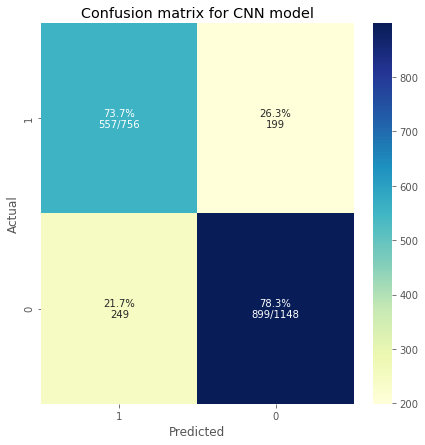

In [130]:
#Showing Confusion Matrix for DNN model

plot_cm(cnn_pred,val_y_cnn, 'Confusion matrix for CNN model', figsize=(7,7))

In [ ]:
cnn_pred = predict(val_X_cnn,model_cnn)
#Predictions for CNN model
for i, j in zip(train_X_cnn[24:50], cnn_pred[24:50]):
    print("Tweet to predict :", i)
    print("The Category found is :", "Disaster tweet" if j==1 else "Not a Disaster tweet")